# Software Notes P - Tackling Multicollinearity: PCA & Ridge Regression

Prepared for ISyE 4031 <br>
Brandon Kang <br>
brandonkang@gatech.edu

> Credit: Some of the images and notations are derived from <a href="https://www2.isye.gatech.edu/~yxie77/ISyE6416SyllabusSpring2019.pdf">ISyE 6416 (Computational Statistics)</a> taught by <a href="https://www2.isye.gatech.edu/~yxie77/">Dr. Yao Xie</a>. One of the images is also derived from a homework problem I solved from her class this semester.

> Credit: One block of code is used from <a href="https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot"> Stack Overflow </a> to produce a PCA biplot.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from jupyterthemes import jtplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
jtplot.style(theme='onedork')

## Introduction

A common problem in many datasets is the tendency of having correlated features, where your features are related to each other. Thinking about this in real world applications, this can easily make sense. For example, take some common features for predicting house prices: numBedrooms, numBathrooms, sqftHouse, etc. You can immediatelly recognize that the number of bedrooms is probably correlated with the number of bedrooms and the square footage of the house. With more bedrooms, there are probably more bathrooms with a higher square footage. 

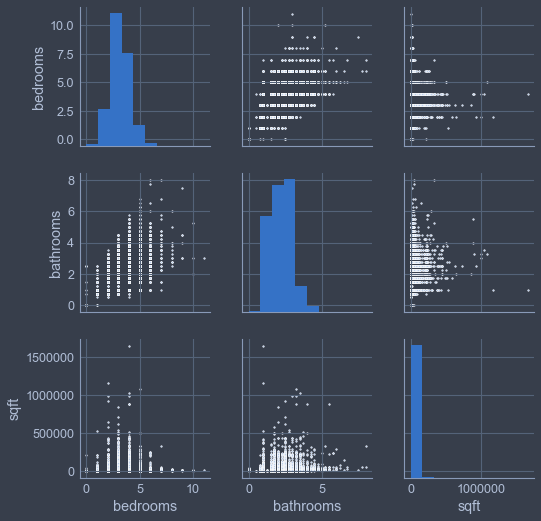

In [2]:
df = pd.read_csv("houseData.csv")
df["sqft"] = df["sqft_living"] + df["sqft_lot"] + df["sqft_above"] + df["sqft_basement"]
df = df.loc[df["bedrooms"]<20]
features = ["bedrooms", "bathrooms", "sqft"]
sns.pairplot(df[features], plot_kws={"s": 2})

Text(0.5, 1, 'Correlation Check')

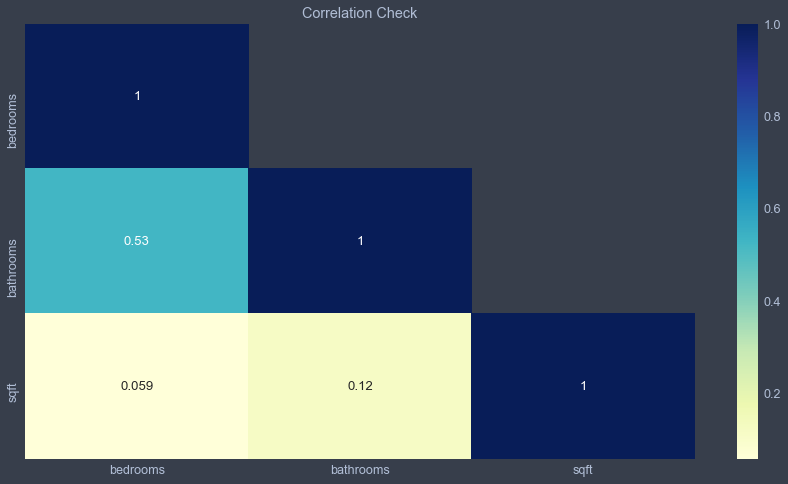

In [3]:
corr = df[features].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, 0)

fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu")
plt.title("Correlation Check")

In the above example, you can see that bedrooms and bathrooms are somewhat correlated, and the other combinations are not. Although a pairwise (Pearson) correlation coefficient of 0.53 is not majorly significant or worrying, other datasets may have higher pairwise correlation coefficients that can be quite troublesome. Furthermore, with large dimensional datasets, it will almost be inevitable that some of your features may be highly correlated. 
> Take a 28x28 image of faces, which can be vectorized to 784 features (where each pixel is a feature). Many of the features can be correlated in their intensities (for example, the pixel intensity of the lips will be concentrated near the bottom of the image for all faces). It is necessary to both reduce the dimesionality (since 784 features is quite large) to avoid **overfitting** but also to reduce **computational runtime**.

Recall from lecture notes that multicollinearity can cause the following issues:
    1. Coefficients can have the wrong signs or magnitude
    2. Omitting a variable causes drastic changes in parameter estimates
    3. Variance of estimators will be quite large
    4. Out of sample predictions will become unreliable

## PCA: Background

A widely popular method for *dimensionality reduction* and tackling *multicollinearity* is using PCA, which essentially creates principal components, or *linear* combinations of the original features along directions that maximize variance, to reduce the dimensionality of the data. That was quite a mouthful, but let's take it step by step. Before we even begin to tackle PCA, let's review some numerical linear algebra, specifically SVD.

### SVD (Singular Value Decomposition)

Recall that SVD (Singular Value Decomposition) is a factorization of a matrix, $A$, to the product of three matrices.
$$
A = U \Sigma V^T
$$
Let's define each matrix.
> $A \in \mathbb{R}^{mxn} $  
 $U \in \mathbb{R}^{mxm}$  
 $\Sigma \in \mathbb{R}^{mxn}$  
 $V \in \mathbb{R}^{nxn}$
 
$U$ and $V$ are left and right orthogonal vectors respectively (where $U U^T = I_m$ and $V V^T=I_n$), and $\Sigma$ is a diagonal matrix containing the singular values, which are the square roots of the eigenvalues from $X^*X$. Here, $*$ represents the transpose conjugate. Note that the singular values on the diagonal are listed in descending order.

>If the original matrix, $A$, is a square matrix, then we may arrive at a special case of SVD known as eigen-decomposition: 
$$
A = U \Sigma U^T
$$
In this case, $U$ corresponds to the eigenvectors and $\Sigma$ corresponds to the eigenvalues. In this case, singular values and eigenvalues coincide. However, not every square matrix has an eigendecomposition, but all matrices have an SVD.

### Low Rank Approximation

Generally, the number of non-zero singular values from $\Sigma < \min\{m, n\}$, which tells us that we can use *low rank approximation* by taking the non-zero singular values to approximate the original matrix, $A$. A low rank approximation is to approximate a matrix (in our case, $A$) with a matrix that has a lower rank (which is the case when the number of non-zero singular values from $\Sigma < \min\{m, n\}$) than the original matrix.
![Image](https://i.gyazo.com/019458d922d9035011a541767aa1c1bc.png)
The above image is visualized in 3 dimensions, but you can clearly see that most of the data points lie along the 2-dimensional axes colored in two shades of red. There will exist a singular value in the diagonal matrix, $\Sigma$ that is quite close to zero and can be dropped when forming the low rank matrix to approximate the original matrix (if we are using 2 singular values to approximate $A$). What this essentially means is that we can approximate the original matrix by only taking the most significant singular values (or the directions where the data points mostly lie on) and excluding the others. 

>This is *very* powerful because we can now represent the original matrix with an approximation that is fairly accurate and can be represented with a much smaller dimensionality.

>The application of SVD and low-rank approximation is **extensive**: image compressing, denoising data, computing matrix pseudo-inverses (e.g. computing multivariate Gaussian pdf for GMM), linear regression, etc.

Below, I included a simple demo using a picture of our classroom. :)

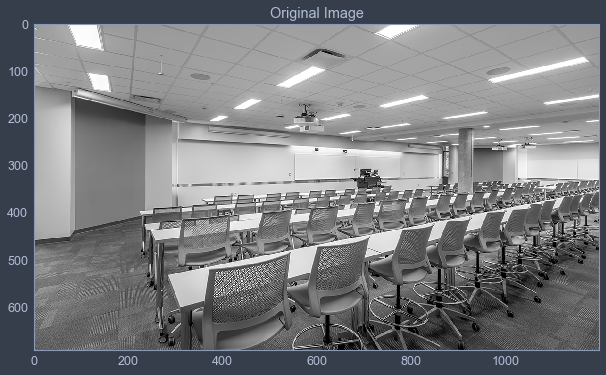

In [4]:
img = Image.open('classroom.jpg')
#greyscale image
imggray = img.convert('LA')
plt.figure(figsize=(12, 6))
plt.imshow(imggray)
plt.title("Original Image")
plt.grid(None)

In [5]:
#store image into a matrix
imgMat = np.matrix(imggray.getdata(band=0), float).reshape(imggray.size[1], imggray.size[0])

In [6]:
#feature size
imgMat.shape[0]*imgMat.shape[1]

830400

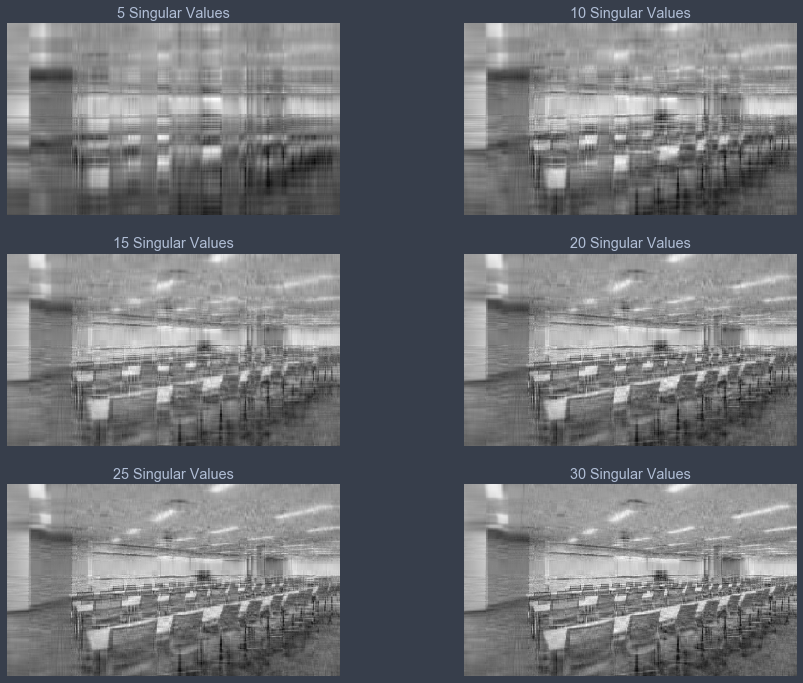

In [7]:
#perform SVD
U, sigma, V = np.linalg.svd(imgMat)

n = np.arange(1, 7)
fig, ax = plt.subplots(3, 2, figsize=(15, 12))

#iterate through different low rank approximations
for comp in n:
    #low rank approximation: keep top x amount of singular values
    approx = np.matrix(U[:, :comp*5]) * np.diag(sigma[:comp*5]) * np.matrix(V[:comp*5, :])
    #plot resulting approximation
    ax[(comp-1)//2, (comp-1)%2].imshow(approx, cmap="gray")
    ax[(comp-1)//2, (comp-1)%2].set_title(str(comp*5) + " Singular Values")
    ax[(comp-1)//2, (comp-1)%2].grid(None)
    ax[(comp-1)//2, (comp-1)%2].axis("off")

In the above demo, you can see that the original picture can be almost recovered using a small number of singular values. The original image was 1200x692 (so 830400 features or pixels), and we recovered the original image quite well with <50 singular values. Also, it should be quite apparent that as you increase the number of singular values, the better you can approximate the original image. 

(-0.5, 1199.5, 691.5, -0.5)

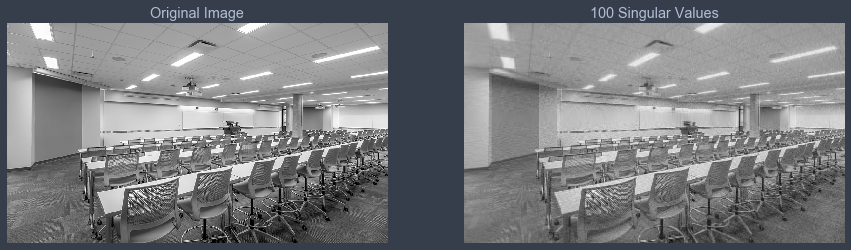

In [8]:
#Compare original image with 100 singular values
fig, ax = plt.subplots(1, 2, figsize=(15, 12))

ax[0].imshow(imggray)
ax[0].set_title("Original Image")
ax[0].grid(None)
ax[0].axis("off")

approx = np.matrix(U[:, :100]) * np.diag(sigma[:100]) * np.matrix(V[:100, :])
ax[1].imshow(approx, cmap="gray")
ax[1].set_title("100 Singular Values")
ax[1].grid(None)
ax[1].axis("off")

## PCA: Formalization

Similarly, real world data exhibit some **low rank structure** due to correlations among variables, and PCA ultimately aims to "rotate" to original data and map to new coordinates using fewer dimensions. For linear regression, it is helpful for **dimensionality reduction** and handling **multicollinearity**. However, before you use PCA, you should ask yourself the following questions:

    1. Are you working with a large dimension dataset? Is PCA really necessary if your feature space is relatively small relative to the number of data points you have (i.e. do you really need dimensionality reduction)?
    2. Are you comfortable with having your features become less interpretable?
    3. Is it important that your features need to be independent from each other?
The second question is especially important. Even though PCA creates linear combinations of features, your new features will be the principal components, and it will be difficult to interpret the results of your model since your features are no longer the original set of features. 

### Principal Component Scores and Projections

Let's define $X \in \mathbb{R}^{nxp}$, where $n$ represents the number of data points, and $p$ represents the number of predictors/features. Our goal is to transform the data set using $k$ principal components that represent the original data, where $k\leq p$. Since we use PCA for $k<p$, this is a form of dimensionality reduction, more specifically a *linear* dimensionality reduction because of the below principal component "scores."
$$
v_j^T x_i \in \mathbb{R}\\
j=1,\dots,k, i=1,\dots,n
$$
The above equation is computing a weighted combination (inner product) of the weights, $v$, and the feature vector, $x_i$. Essentially, you are *projecting* $x$ along $v$. This returns to us a real number known as a principal component *score*.

![Image](https://i.gyazo.com/59ed2b9e32e9c5fb3f1ea7324eb215c0.png)

By mapping this score onto the direction of $v$ (which is unit length), this is also viewed as a *projection* of each data point along the direction of a principal component. Note that this is computed $k$ times, where $k$ is the number of principal components. Therefore, we are reducing the dimensionality from $p$ to $k$.

![Image](https://i.gyazo.com/7c935f6518093d889c63c3e68c98d172.png)
Above is an application of what we've covered. Our data has 2 features, and we are using 2 principal components along $v_1$ and $v_2$. Note that the scores for each data point are first computed, and then mapped along the direction of $v_1$ and $v_2$.

### First Principal Component

The main question is how do we deterime these directions? We want to choose directions that maximize variance, or essentially, the directions that give us the most information. 

The *first principal component direction*, $v_1$, is one that maximizes the sample variance of $Xv_1 \in \mathbb{R}^n$ (recall that $X$ represents all data points). In other words, this is an optimization problem:
$
\newcommand\norm[1]{\left\lVert#1\right\rVert}
\DeclareMathOperator*{\argmax}{argmax}
$
$$
v_1 =  \underset{\norm{v}_2=1}{\argmax} (Xv)^T(Xv) 
$$
Essentially, $v_1$ will correspond to the singular vector of the largest singular value of $X^TX$, which is the sample covariance matrix. Imagine this covariance matrix as a matrix that explains how each variable is associated with each other variable in $X$. Note that $X^TX$ is square, so we can use eigendecomposition or SVD with matrix, $A=X^TX$, to find $v$.

> 1. $v_1$ corresponds to the largest eigenvector of $X^TX$ (recall singular vectors coincide with eigenvectors for square matrices).
2. $(Xv_1)^T(Xv)=v^TX^TXv_1$ corresponds to the largest eigenvalue of $X^TX$ and represents the variance explained by $v_1$


### Beyond First Principal Component

Once we determine the first principal component, we continue finding others until we reach $k$ principal components. We want to ensure that the principal components are *orthogonal* to each other. Because we have already explained the variance along $v_1$, we want the directions to be orthogonal to ensure that there is no redundancy or overlap between the principal components in order to ensure we are maximizing the variance. Essentially, this can be formulated as the following:
$$
v_k=\underset{\norm{v}_2=1,\; v^Tv_j=0, \; j=1,\dots,k-1}{\argmax}(Xv)^T(Xv)
$$
![Image](https://www.analyticsvidhya.com/wp-content/uploads/2016/03/2-1-e1458494877196.png)

### Demo and Choosing $k$

In [9]:
dfHouses = pd.read_csv("houseData2.csv", index_col=0)
features = list(dfHouses.columns.drop(["price", "date"]))
X = dfHouses[features]
y = dfHouses["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [10]:
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,
8682300890,2,2.50,2380,6600,1.0,0,0,3,8,2380,0,2010,0,98053,47.7170,-122.020,1870,6600
8073000550,4,3.75,3190,17186,2.0,1,4,3,10,3190,0,1999,0,98178,47.5115,-122.246,2290,13496
7212680850,3,2.50,1730,6930,2.0,0,0,3,8,1730,0,1994,0,98003,47.2621,-122.308,1780,6930
8880600070,4,2.00,1870,8750,1.0,0,2,3,7,1870,0,1977,0,98022,47.1985,-122.001,1770,8207
7226500100,8,3.00,2850,12714,1.0,0,0,3,7,2850,0,1959,0,98055,47.4859,-122.205,1480,4942


In [11]:
#PCA is affected by scale, so need to standardize
scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)

In [12]:
explainedVar = []
comp = np.arange(1, len(X_train.columns)+1)

for n in comp:
    pca = PCA(n_components=n)
    pca_result = pca.fit_transform(X_train_standard)
    explainedVar.append(np.sum(pca.explained_variance_ratio_))

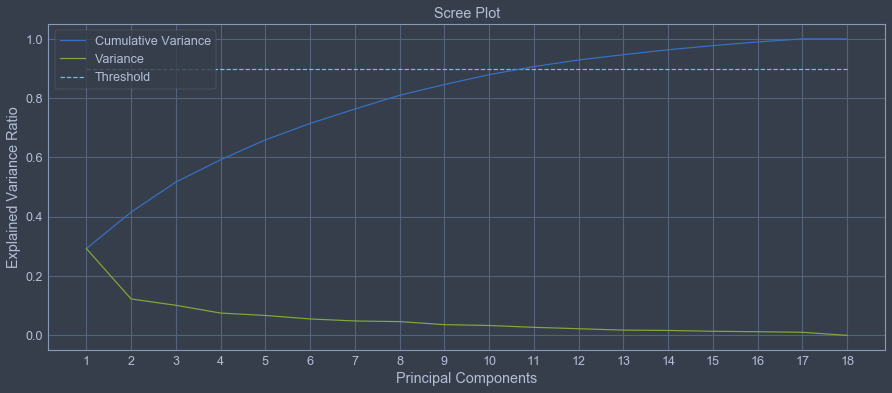

In [14]:
plt.figure(figsize=(15, 6))
plt.plot(comp, explainedVar, label="Cumulative Variance")
plt.plot(comp, pca.explained_variance_ratio_, label="Variance")
plt.title("Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.hlines(0.9, 1, 18, colors="c", linestyles="dashed", label="Threshold")
plt.legend()
xint = range(min(comp), (max(comp))+1)
plt.xticks(xint)
plt.show()

Note that the above plot is called a "scree plot." For choosing $k$, you can follow two procedures:
>1. Find an *elbow point* in the scree plot (a point of inflection where the function starts to flatten). In the above visualization, we can't really visualize an elbow point, so we proceed with 2.
2. Determine a *threshold* for explained variance. How much variability do you want to be explained in the principal components. For example, I set the threshold to 90%, and we can see that at 11 principal components, we can explain 90% of the variability. 

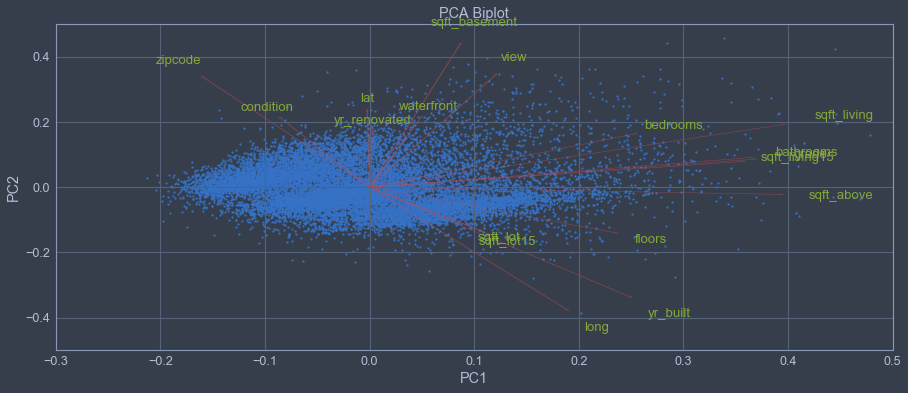

In [38]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train_standard)

#from https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
def myplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(15, 6))
    plt.scatter(xs * scalex,ys * scaley, s=4)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, X_train.columns[i], color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    
    plt.xlim(-0.3, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid(True)
    plt.title("PCA Biplot")

#pca.components_ gives the eigenvectors 
myplot(pca_result, np.transpose(pca.components_[0:2, :]))
plt.show()

Although the above plot is more helpful for classification tasks to see if the points among different classes are well separated, it still shows us that some features like sqft are correlated with each other since they point along the same direction. Also, it shows that sqft strongly influence PC1, whereas lat/yr_renovated strongly influence PC2. You can now visually see that PCA tackles multicollinearity by essentially "combining" some correlated variables into principal components.

In [15]:
pca = PCA(n_components=11)
pca_result = pca.fit_transform(X_train_standard)

dfPCA = pd.DataFrame(pca_result)
newCol = ["PC" + str(col+1) for col in dfPCA.columns]
dfPCA.columns = newCol
dfPCA["price"] = y_train.values

In [16]:
formula = "price ~"
for col in newCol:
    if col=="PC11":
        formula += " " + col
    else:
        formula += " " + col + " +"
        
model = ols(formula, data=dfPCA).fit() 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     2918.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:41:43   Log-Likelihood:            -2.0660e+05
No. Observations:               15117   AIC:                         4.132e+05
Df Residuals:                   15105   BIC:                         4.133e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    5.42e+05   1697.071    319.395      0.000    5.39e+05    5.45e+05
PC1         1.005e+05    739.219    135.978      0.000    9.91e+04    1.02e+05
PC2         1.124e+05   1141.559     98.468      0.000     1.1e+05    1.15e+05
PC3         2598.5658   1255.830      2.069      0.039     136.987    5060.145
PC4          3.31e+04   1458.001     22.699      0.000    3.02e+04     3.6e+04
PC5         7180.9932   1543.986      4.651      0.000    4154.593    1.02e+04
PC6        -1.621e+04   1699.160     -9.542      0.000   -1.95e+04   -1.29e+04
PC7        -9.314e+04   1815.196    -51.309      0.000   -9.67e+04   -8.96e+04
PC8        -9911.3870   1855.656     -5.341      0.000   -1.35e+04   -6274.076
PC9        -2.711e+04   2105.007    -12.881      0.000   -3.12e+04    -2.3e+04
PC10       -5341.8344   2189.891     -2.439      0.015   -9634.287   -1049.382
PC11        5.144e+04   2428.550     21.182      0.000    4.67e+04    5.62e+04
==============================================================================
Omnibus:                    12853.535   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1145720.719
Skew:                           3.605   Prob(JB):                         0.00
Kurtosis:                      45.035   Cond. No.                         3.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
train = X_train.copy()
train["price"] = y_train.values
formula = "price ~"
for col in train.columns:
    if col=="sqft_lot15":
        formula += " " + col
    elif col!="price":
        formula += " " + col + " +"
        
model = ols(formula, data=train).fit() 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     2129.
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:41:44   Log-Likelihood:            -2.0597e+05
No. Observations:               15117   AIC:                         4.120e+05
Df Residuals:                   15099   BIC:                         4.121e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.645e+06   3.48e+06      1.909      0.056   -1.78e+05    1.35e+07
bedrooms      -3.646e+04   2343.555    -15.557      0.000   -4.11e+04   -3.19e+04
bathrooms      4.406e+04   3915.200     11.253      0.000    3.64e+04    5.17e+04
sqft_living     106.5377      2.732     38.990      0.000     101.182     111.894
sqft_lot          0.0972      0.056      1.726      0.084      -0.013       0.207
floors         1.007e+04   4282.272      2.351      0.019    1675.349    1.85e+04
waterfront     6.055e+05   2.04e+04     29.650      0.000    5.66e+05    6.46e+05
view           5.083e+04   2548.366     19.945      0.000    4.58e+04    5.58e+04
condition      2.852e+04   2798.610     10.190      0.000     2.3e+04     3.4e+04
grade          1.006e+05   2572.584     39.110      0.000    9.56e+04    1.06e+05
sqft_above       62.7398      2.688     23.342      0.000      57.471      68.008
sqft_basement    43.7970      3.151     13.899      0.000      37.621      49.973
yr_built      -2701.0872     86.317    -31.293      0.000   -2870.278   -2531.896
yr_renovated     20.3136      4.373      4.645      0.000      11.742      28.886
zipcode        -563.1330     39.141    -14.387      0.000    -639.854    -486.412
lat            5.828e+05   1.28e+04     45.450      0.000    5.58e+05    6.08e+05
long          -2.083e+05   1.56e+04    -13.381      0.000   -2.39e+05   -1.78e+05
sqft_living15    28.6186      4.124      6.940      0.000      20.536      36.702
sqft_lot15       -0.4215      0.086     -4.898      0.000      -0.590      -0.253
==============================================================================
Omnibus:                    12307.009   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           984498.875
Skew:                           3.389   Prob(JB):                         0.00
Kurtosis:                      41.950   Cond. No.                     5.28e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.5e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Relatively equal performance using PCA and using all features, mainly because feature space is small and we have many data points. As you scale up with datasets with large feature dimensionality, PCA and dimensionality reduction will be especially helpful for combatting against overfitting and minimizing computational expense. 

## Ridge Regression

One issue with multicollinearity is its tendency to inflate the variance of the estimators and cause wild changes in the estimated coefficients. Similarly to Lasso Regression, which is in <a href="https://brandonbks.github.io/static/sn5.html">Software Notes 5</a>, we are trying to constrain the size of the coefficients to reduce the variance in our model. I highly suggest to review the "Lasso Regression" section first, as I detail some effects from overfitting and to compare the optimization problems between the two. Let's detail the constrained optimization problem, which is quite similar to that of Lasso Regression except for one change. Note that there is also another Lagrangian multiplier here similar to that of Lasso Regression.
$$
\begin{align}
\min_\hat{\beta} \norm{y-X\hat{\beta}}_2^2 + \lambda \norm{\hat{\beta}_k}_2^2
\end{align}
$$
In Lasso Regression, we are using the L1-norm of the coefficients, but with Ridge Regression, we are trying to limit the square of the L2-norm (sum of each squared predictor). Again, $\lambda$ is a regularization parameter that we must tune through cross validation that controls the strength of the penalization term. As you increase it, the $\beta$ tend to 0. 

![Image](https://i.gyazo.com/7a9c616fc1639d3836a07e4e4cab511f.png)
It is important to recognize the geometric differences of Lasso (left) and Ridge (right) Regression. Note that Lasso Regression may force some coefficients to zero due to its geometry, but Ridge Regression does NOT. This is why Lasso Regression can be used as a variable selection method, but Ridge Regression cannot.

You can see that the size of the coefficients is controlled and shrinked because the constraints on the coefficients limits the solution space. Furthermore, this is shown below, where alpha represents the regularization parameter.
![Image](https://i.gyazo.com/eb47d7d2188ea1c2a6927914aaf5cbb7.png)

Instead, Ridge Regression is used for controlling the effects of multicollinearity. Note that we can find a closed-form expression for Ridge Regression.
$$
\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty
$$
Compare this to the closed-form expression of ordinary regression.
$$
\hat{\beta}=(X^TX)^{-1}X^Ty
$$
In the presence of multicollinearity, the matrix, $X^TX$ is not invertible, so there is no feasible solution for ordinary regression. However, adding *nearly any* pertubation in the form of $\lambda I$ will force the matrix to to become non-singular and thus invertible, which is how Ridge Regression combats multicollinearity.

### Demo

In [64]:
alpha = np.arange(0.001, 100, 0.1)
ridge = RidgeCV(alphas=alpha, store_cv_values=True).fit(X_train_standard, y_train)

In [65]:
ridge.alpha_

49.801

Text(0.5, 1.0, 'Ridge Regression MSE')

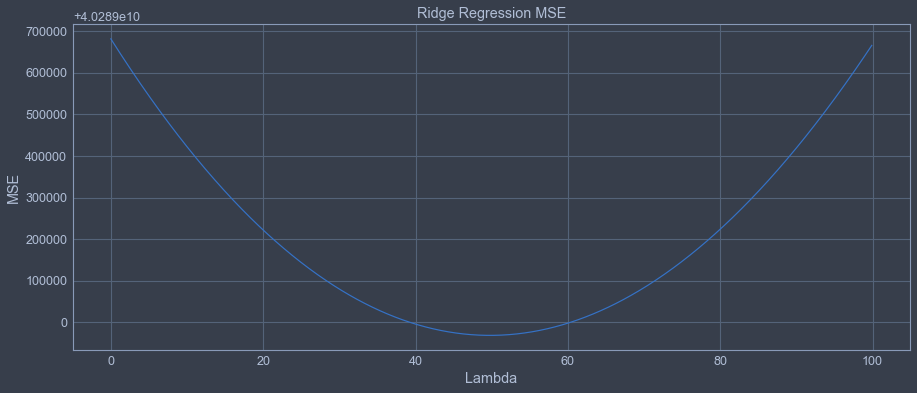

In [66]:
cvDict = dict(zip(alpha, np.mean(ridge.cv_values_, axis=0)))
plt.figure(figsize=(15, 6))
sns.lineplot(list(cvDict.keys()), list(cvDict.values()))
plt.ylabel("MSE")
plt.xlabel("Lambda")
plt.title("Ridge Regression MSE")

You can clearly visualize that MSE is minimized between 40 and 60 (at $\alpha=49.801$). Therefore, this is the value we will use for Ridge Regression.